🔑 หลักที่จะยึด (ตรงกับตอนเทรน)

จากโค้ดเทรน:

1 sample = 1 คน

30 frame ต่อเนื่อง

joint_id ตรง

normalize center (hip)

score อยู่ channel 3

คนเดียวกันตลอด T

ดังนั้น realtime ต้อง:

รักษา identity consistency

เก็บ buffer ต่อคน

ส่งเข้า model เมื่อครบ T

In [15]:
# จากตอนสร้างกราฟ

T = 30
C = 3
V = 17
M = 1

label_to_video = {
    0: 'Hoang_Hearn',
    1: 'Kum_Pa_Gun_Poong_Hork',
    2: 'Mek_Khara_Lor_Kaew',
    3: 'Narai_Kwang_Jug',
    4: 'Phra_Ram_Phang_Sorn',
    5: 'Tad_Mai_Khom_Nam'
}

In [16]:
COCO_JOINTS = {
    0: "nose",
    1: "left_eye",
    2: "right_eye",
    3: "left_ear",
    4: "right_ear",
    5: "left_shoulder",
    6: "right_shoulder",
    7: "left_elbow",
    8: "right_elbow",
    9: "left_wrist",
    10: "right_wrist",
    11: "left_hip",
    12: "right_hip",
    13: "left_knee",
    14: "right_knee",
    15: "left_ankle",
    16: "right_ankle",
}

SKELETON = [
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 6),
    (5, 11), (6, 12),
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
]

In [17]:
from ultralytics import YOLO

pose_model = YOLO("yolov8l-pose.pt")


In [18]:
import torch
import torch.nn as nn

# ---------- Graph Convolution ----------
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.A = nn.Parameter(
            torch.tensor(A, dtype=torch.float32),
            requires_grad=False
        )  # (K, V, V)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (N*M, C, T, V)
        A = self.A.to(x.device)
        x = torch.einsum("nctv,kvw->nctw", x, A)
        x = self.conv(x)
        return x


# ---------- ST-GCN Block ----------
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, dropout=0.0):
        super().__init__()

        self.gcn = GraphConv(in_channels, out_channels, A)

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),
                padding=(4, 0),
                stride=(stride, 1)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout)   # dropout อยู่ตรงนี้
        )

        # residual
        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        return self.relu(x + res)


# ---------- ST-GCN Model ----------
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, A):
        super().__init__()

        self.layer1 = STGCNBlock(in_channels, 64,  A, stride=1, dropout=0.1)
        self.layer2 = STGCNBlock(64, 128, A, stride=2, dropout=0.3)
        self.layer3 = STGCNBlock(128, 256, A, stride=2, dropout=0.3)

        self.dropout = nn.Dropout(0.5)  # ก่อน fc
        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.shape

        # -------- Input normalization (สำคัญมาก) --------
        x[:, 0:2] = x[:, 0:2] - x[:, 0:2].mean(dim=3, keepdim=True)
        x[:, 0:2] = x[:, 0:2] / (x[:, 0:2].std() + 1e-6)

        # flatten person
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        x = x.view(N * M, C, T, V)

        # ST-GCN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # global average pooling
        x = x.mean(dim=2).mean(dim=2)   # (N*M, C)

        # restore person
        x = x.view(N, M, -1).mean(dim=1)

        x = self.dropout(x)
        return self.fc(x)


In [19]:
data = torch.load("stgcn_dataset.pt", map_location="cpu")
A       = data["graph"]      # (3, V, V)

C:\Users\User\AppData\Local\Temp\ipykernel_16296\1797858249.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("stgcn_dataset.pt", map_location="cpu")


In [20]:
model = STGCN(
    in_channels=3,
    num_class=6,   # จาก label_to_video มี 6 class
    A=A            # adjacency matrix ตัวเดิม
)

C:\Users\User\AppData\Local\Temp\ipykernel_16296\4124120401.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(A, dtype=torch.float32),


In [21]:
device = next(model.parameters()).device
model_path = "stgcn_trained_v2.pt"
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [22]:
import cv2
import torch
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ---------------- config ----------------
T = 30                       # ต้องตรงกับตอน train
HIP_JOINT = 11               # COCO: left_hip = 11, right_hip = 12
DIST_THRESH = 80
MAX_MISS = 10

# ---------------- utils ----------------
def coco_to_tensor(kpts, scores):
    """
    return: (3, 17)
    """
    pose = np.zeros((3, 17), dtype=np.float32)
    pose[0] = kpts[:, 0]
    pose[1] = kpts[:, 1]
    pose[2] = scores
    return pose

def normalize_center_hip(x):
    """
    x: (3, T, 17)
    normalize by hip joint (x,y only)
    """
    hip = x[:2, :, HIP_JOINT].mean(axis=1, keepdims=True)  # (2,1)
    x[:2] -= hip[:, None]
    return x

def get_center(kpts):
    valid = kpts[(kpts[:, 0] > 0) & (kpts[:, 1] > 0)]
    if len(valid) == 0:
        return None
    return valid.mean(axis=0)


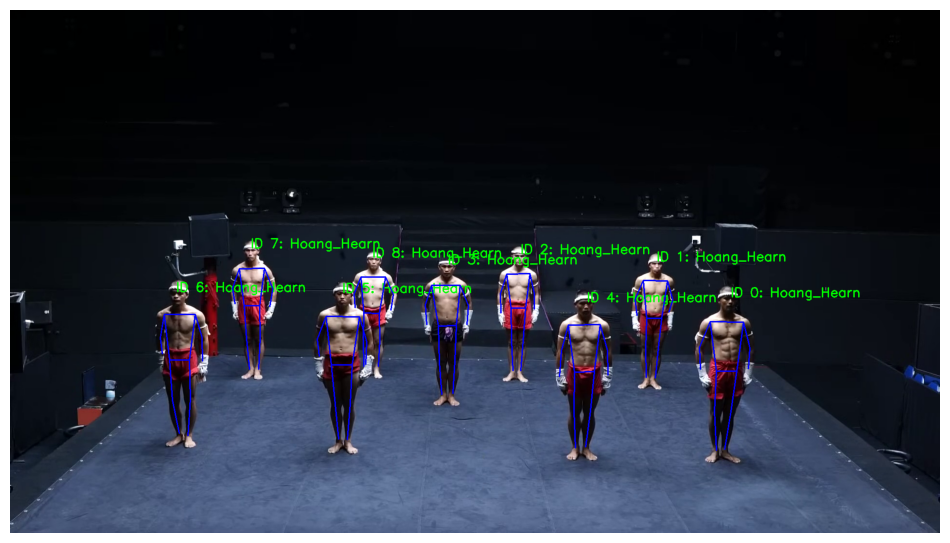

In [23]:
device = next(model.parameters()).device
model.eval()

cap = cv2.VideoCapture("muay_thai_clip.mp4")

# ---------------- buffers ----------------
person_buffers = defaultdict(list)   # pid -> [pose_t]
person_centers = {}
person_last_pred = {}
person_miss = {}

next_person_id = 0
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    detected_ids = set()

    # ---------- Pose detection ----------
    results = pose_model(frame, conf=0.25, device=0, verbose=False)
    r = results[0]

    if r.keypoints is None:
        continue

    keypoints = r.keypoints.xy.cpu().numpy()     # (N,17,2)
    scores    = r.keypoints.conf.cpu().numpy()   # (N,17)

    # ---------- loop persons ----------
    for kpts, scs in zip(keypoints, scores):

        center = get_center(kpts)
        if center is None:
            continue

        # ----- identity assignment -----
        best_pid, best_dist = None, 1e9
        for pid, prev_center in person_centers.items():
            d = np.linalg.norm(center - prev_center)
            if d < best_dist and d < DIST_THRESH:
                best_pid, best_dist = pid, d

        if best_pid is None:
            pid = next_person_id
            next_person_id += 1
        else:
            pid = best_pid

        detected_ids.add(pid)
        person_centers[pid] = center
        person_miss[pid] = 0

        # ---------- build pose ----------
        pose = coco_to_tensor(kpts, scs)  # (3,17)
        person_buffers[pid].append(pose)

        # ---------- infer only when EXACTLY T frames ----------
        if len(person_buffers[pid]) == T:

            data = np.stack(person_buffers[pid], axis=1)   # (3,T,17)
            data = normalize_center_hip(data)
            data = data[..., None]                          # (3,T,17,1)

            data = torch.tensor(data).float().unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model(data).argmax(dim=1).item()

            # ✅ FIX: map class index → label string
            person_last_pred[pid] = label_to_video.get(pred, "unknown")

            # reset buffer (match train)
            person_buffers[pid].clear()

        # ---------- draw skeleton ----------
        for j1, j2 in SKELETON:
            x1, y1 = kpts[j1]
            x2, y2 = kpts[j2]
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(
                    frame,
                    (int(x1), int(y1)),
                    (int(x2), int(y2)),
                    (255, 0, 0),
                    2
                )

        # ---------- draw label ----------
        label = person_last_pred.get(pid, "collecting...")
        x0, y0 = kpts[0]
        if x0 > 0 and y0 > 0:
            cv2.putText(
                frame,
                f"ID {pid}: {label}",
                (int(x0), int(y0) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0, 255, 0),
                2
            )

    # ---------- handle missing persons ----------
    for pid in list(person_centers.keys()):
        if pid not in detected_ids:
            person_miss[pid] += 1
            if person_miss[pid] > MAX_MISS:
                person_centers.pop(pid)
                person_buffers.pop(pid, None)
                person_last_pred.pop(pid, None)
                person_miss.pop(pid)

    # ---------- show ----------
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 12))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
    clear_output(wait=True)

cap.release()
